Continuation: Epidemic Models and Parameter Optimization, Christopher Monterola* and Erika Legara

-----
*Communications to:    
cmonterola@aim.edu  
Head, Aboitiz School of Innovation, Technology and Entrepreneurship (ASITE)   
Head, Analytics, Computing and Complex Systems Laboratory (ACCeSs)   
Professor, Asian Institute of Management (AIM)    
Website: www.chrismonterola.net

---

## <font color = "darkblue"> Section 3. Changing Reproduction Number $R_0$</font>


The basic reproduction number, $R_0$, is defined as the expected number of secondary cases produced by a single (typical) infection in a completely susceptible population. It is important to note that $R_0$ is a dimensionless number and not a rate, which would have units of time$^{−1}$. Having a value of 2.69 means that a single infected individual can spread the disease to 2.69 individuals before the infected individual dies or becomes non-susceptible to the disease. 

In general, $R_0$ is simply the product of the transmissibility, mean contact rate, and the duration of infection.

**Why we care so much about R0? Let me outline 5 reasons:**

1. $R_0$ is the threshold parameter that determines whether or not there will be an epidemic.
2. $R_0$ determines the critical vaccination threshold $(1 -$ $\frac{1}{R_0})$.
3. $R_0$ determines the initial rate of increase of an epidemic (i.e., during its exponential growth phase).
4. $R_0$ determines the final size of the epidemic (i.e., what fraction of susceptibles will ultimately be infected over the course of the outbreak).
5. $R_0$ determines the endemic equilibrium fraction of susceptibles in the population(= $\frac{1}{R0}$).

Endemic means having the presence of but not growing exponentially in the population. For example as a result of vaccination chickenpox is endemic in UK or tuberculosis is endemic in the Philippines.    

Bettencourt & Ribeiro's approach of calculating $R_0$ is quite straightforward and it uses Bayes' Theorem in calculating the variation of $R_0$ by looking at previous cases collected. Again, recall that Bayes' theorem can be written as:

$$ P(R_t|k)=\frac{P(R_t)\cdot P(k|R_t)}{P(k)} $$

This says that, having seen $k$ new cases, we believe the distribution of $R_t$ is equal to:

- The __prior__ beliefs of the value of $P(R_t)$ without the data ...
- times the __likelihood__ of $R_t$ given that we've seen $k$ new cases or $P(k|R_t)$...
- divided by the probability $P(k)$ of seeing this many cases in general.

Noting that $P(k)$ is a constant we approximate that the numerator is proportional to the posterior. Since all probability distributions sum to 1.0, we can ignore $P(k)$ and normalize our posterior to sum to 1.0:

$$ P(R_t|k) \propto P(R_t) \cdot P(k|R_t) $$ or more generally,

And more generally:

$$ P(R_t|k_t) \propto P(R_0) \cdot {\displaystyle \prod^{T}_{t=0}}P(k_t|R_t) $$

With a uniform prior $P(R_0)$, this reduces to:

$$ P(R_t|k_t) \propto {\displaystyle \prod^{T}_{t=0}}P\left(k_t|R_t\right) $$


A proposed modification was put forward by ([K Systrom, 2020]) to remove the weakness of the above model where the posterior on any given day is equally influenced by the distant past as much as the recent day. The author argued that for epidemics that have $R_t>1$ for a long time and then become under control ($R_t<1$), the posterior gets stuck. It cannot forget about the many days where $R_t>1$ so eventually $P(R_t|k)$ asymptotically approaches 1 when we know it's well under 1. Bettencourt *et al* actual note this in their paper as a footnote. Unfortunately as Systrom pointed out, *The most critical thing to know is when we've dipped below the 1.0 threshold!* and hence a proposal is made to only incorporate the last $m$ days of the likelihood function. By doing this, the algorithm's prior is built based on the recent past which is a much more useful prior than the entire history of the epidemic. So this simple, but important change leads to the following:

$$ P(R_t|k_t) \propto {\displaystyle \prod^{T}_{t=T-m}}P\left(k_t|R_t\right) $$

While this takes the last $m$ priors into account equally, you can decide to apply a windowing function (such as an exponential) to favor recent priors over more distant. 

For cases of COVID19 i believe this is a very sensible assumption as it takes care of the variation of testing kits across time and assumes that the dynamics of people movement and testing numbers are best projected using only the most recent cases. In the simulation below we use $m=7$, that can be interpreted as ** a projection that the dynamics today is more linked to the last seven days as compared to distant past dates**. This is a very sensible assumption. To illustrate note that for Philippines the dynamics in  the first week of March (classes is regular) is different from second week of March (cancellation of classes) and different again in the third week of March (quarantine/lockdown), and so on. 

We follow the derivation of Bettencourt and chooses a likelihood function function that says how likely a value of $R_t$ is given an observed number of new cases $k$. Any time you need to model 'arrivals' over some time period of time we normally approximate it using the [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution). Given an average arrival rate of $\lambda$ new cases per day, the probability of seeing $k$ new cases is distributed according to:

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

This is a good model as it can take care of the  exponential (onset), linear (near the peak) and possibly powerlaw components of the curve. Note too that such function can fit pretty well the usual SIR model solution as a function of time. The Poisson distribution says that if you think you're going to have $\lambda$ cases per day, you'll probably get that many, plus or minus some variation based on chance.

But in our case, we know there have been $k$ cases and we need to know what value of $\lambda$ is most likely. In order to do this, we fix $k$ in place while varying $\lambda$. __This is called the likelihood function.__


__The key insight to making this work is to realize there's a connection between $R_t$ and $\lambda$__. [The derivation](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) is here.

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

where $\gamma$ is the reciprocal of the serial interval ([about 4-5 days for COVID19](https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article)). Since we know every new case count on the previous day, we can now reformulate the likelihood function as a Poisson parameterized by fixing $k$ and varying $R_t$.

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

$$\mathcal{L}\left(R_t|k\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$


#### Implementation using Philippines Data
This implementation is adapted from [K. Systrom, 2020](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from kshelper import *

%matplotlib inline

In [2]:
df = pd.read_excel('RP_recent.xlsx')
df.head()

,Date,Cases,Deaths,Cumulative Cases,Cumulative Deaths
0,2020-03-14,13,3,13,3
1,2020-03-15,47,3,60,6
2,2020-03-16,29,4,89,10
3,2020-03-17,2,1,91,11
4,2020-03-18,45,2,136,13


In [3]:
y_cases=df['Cases']

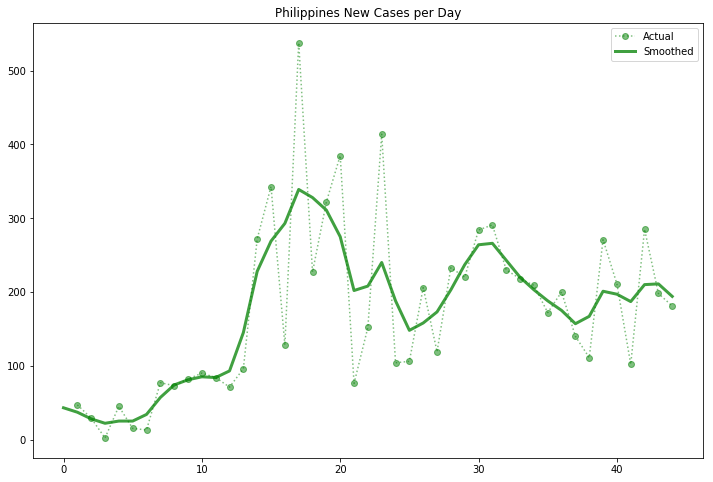

In [4]:
cases=y_cases
cases=np.cumsum(cases)
original, smoothed_cases = prepare_cases(cases, window_time = 7
                                        )

#original = original - .5
original.plot(title="Philippines New Cases per Day", marker='o',
               c='g', linestyle=':', alpha=.5,
               label='Actual', legend=True, figsize=(12, 8))

ax = smoothed_cases.plot(label='Smoothed',
                   legend=True, c='g', lw= 3, alpha = 0.75)

ax.get_figure().set_facecolor('w')

In [5]:
cases=y_cases
cases=np.cumsum(cases)
original, smoothed_cases = prepare_cases(cases, window_time = 7)

Just like the example before, we create lambda based on the previous day's counts from all values of $R_t$. Unlike the previous example, I now evaluate the __log__ of the Poisson. Why? It makes windowing easier.

Since $\log{ab}=\log{a}+\log{b}$, we can do a rolling sum over the last $m$ periods and then exponentiate to get the rolling product of the original values. This does not change any of the numbers – it's just a convenience.

In [6]:
GAMMA = 1/4
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

posteriors_cases = get_posteriors(smoothed_cases, g = GAMMA, \
                                  rtrange = r_t_range, window = 7)

### The Result

Below you can see every day (row) of the posterior distribution plotted simultaneously. The posteriors start without much confidence (wide) and become progressively more confident (narrower) about the true value of $R_t$

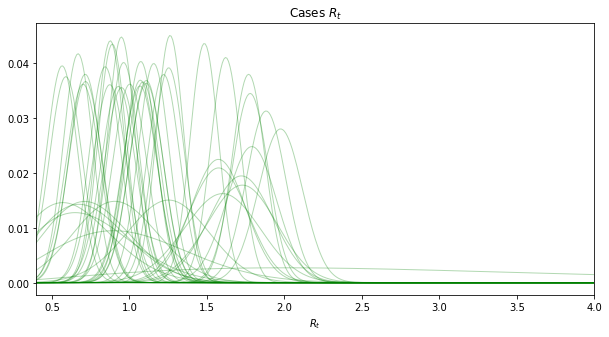

In [7]:
ax = posteriors_cases.plot(title='Cases $R_t$',
           legend=False, 
           lw=1,
           c='g',
           alpha=.3,
           xlim=(0.4,4), figsize=(10, 5))

ax.set_xlabel('$R_t$');

### Plotting in the Time Domain with Credible Intervals

Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.

In [8]:
hdi = highest_density_interval(posteriors_cases, p=.95)

# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors_cases)

most_likely = posteriors_cases.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low,High
40,0.93,0.71,1.15
41,0.95,0.72,1.16
42,1.07,0.85,1.29
43,1.11,0.89,1.32
44,1.11,0.90,1.33


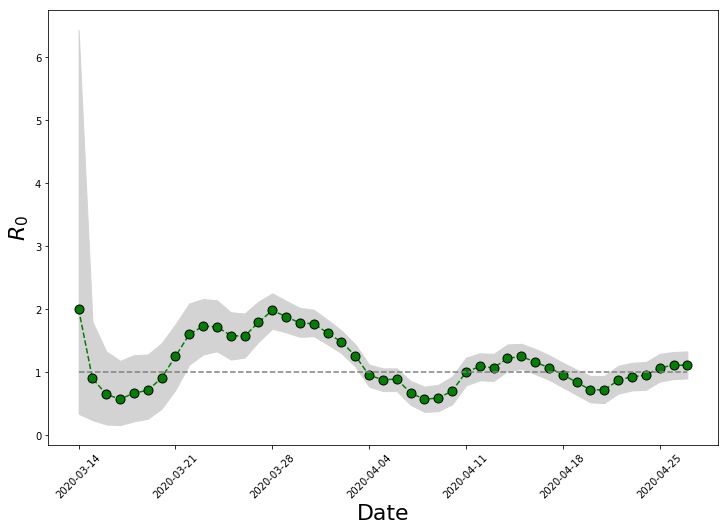

In [9]:
## Put zero in front of results if no cases exist at the onset
nodata=len(df['Date'])-len(result)
scaled = np.zeros((nodata,3))
result = np.concatenate((scaled,result))
result=pd.DataFrame(result, columns=['ML', 'Low', 'High'])

#Cases
plt.figure(figsize=(12,8))
plt.plot(df['Date'], result['ML'], 'o--',color='green',markersize=9, markeredgecolor='black' )
plt.xticks(rotation=45)
plt.plot(df['Date'], [1]*len(result.index), '--',color='gray')
plt.fill_between(df['Date'], result['Low'], result['High'], color='lightgray')
plt.xlabel('Date', size=22);
plt.ylabel('$R_0$', size=22);

plt.show()

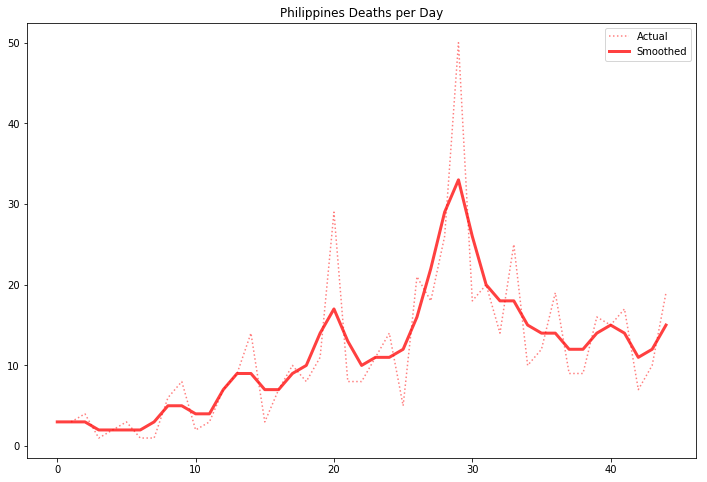

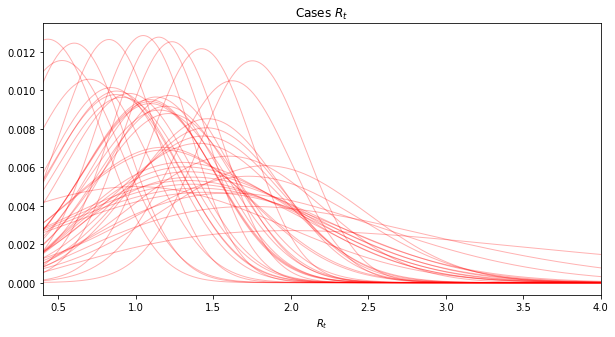

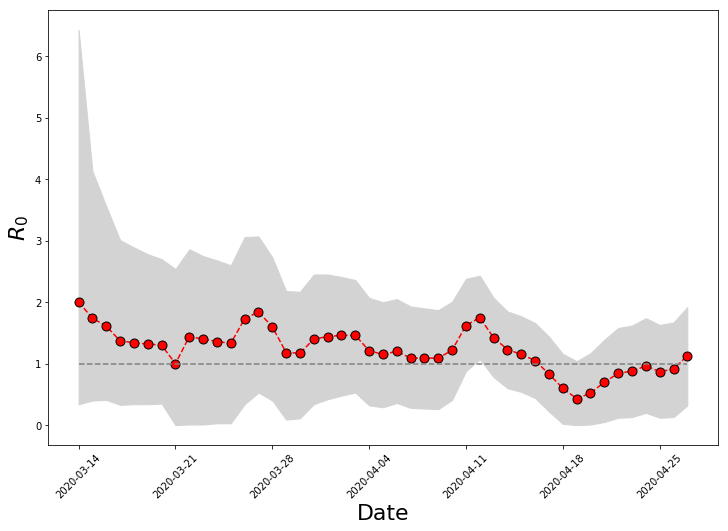

In [10]:
y_cases=df['Deaths']
cases=y_cases
cases=np.cumsum(cases)
original, smoothed_cases = prepare_cases(cases, window_time = 7)

original.plot(title="Philippines Deaths per Day",
               c='r', linestyle=':', alpha=.5,
               label='Actual', legend=True, figsize=(12, 8))

ax = smoothed_cases.plot(label='Smoothed',
                   legend=True, c='r', lw= 3, alpha = 0.75)

ax.get_figure().set_facecolor('w')

cases=y_cases
cases=np.cumsum(cases)
original, smoothed_cases = prepare_cases(cases, window_time = 7)

GAMMA = 1/4
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

posteriors_cases = get_posteriors(smoothed_cases, g = GAMMA, \
                                  rtrange = r_t_range, window = 7)

ax = posteriors_cases.plot(title='Cases $R_t$',
           legend=False, 
           lw=1,
           c='r',
           alpha=.3,
           xlim=(0.4,4), figsize=(10, 5))

ax.set_xlabel('$R_t$');

hdi = highest_density_interval(posteriors_cases, p=.95)

# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors_cases)

most_likely = posteriors_cases.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

## Put zero in front of results if no cases exist at the onset
nodata=len(df['Date'])-len(result)
scaled = np.zeros((nodata,3))
result = np.concatenate((scaled,result))
result=pd.DataFrame(result, columns=['ML', 'Low', 'High'])

#Cases
plt.figure(figsize=(12,8))
plt.plot(df['Date'], result['ML'], 'o--',color='r',markersize=9, markeredgecolor='black' )
plt.xticks(rotation=45)
plt.plot(df['Date'], [1]*len(result.index), '--',color='gray')
plt.fill_between(df['Date'], result['Low'], result['High'], color='lightgray')
plt.xlabel('Date', size=22);
plt.ylabel('$R_0$', size=22);

plt.show()